# Preprocessing

Importing base libraries

In [75]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

Reading csv file

In [29]:
data = pd.read_csv('database/hmeq.csv')
# mostrar primeros registros
data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


Observing that DEROG and DELINQ are integer values, so they are removed from all transformation on numerical features

In [30]:
data['DEROG'] = data['DEROG'].astype(object)
data['DELINQ'] = data['DELINQ'].astype(object)

Dtypes and null values

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   object 
 8   DELINQ   5380 non-null   object 
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 605.4+ KB


Dataframe dimension

In [4]:
print(data['BAD'].shape)
print(data['BAD'].unique().shape)

(5960,)
(2,)


Checking on main statistics values

In [32]:
data.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,1168.233561,17.000000,71.000000,203.312149


Dividing dataframe into X and y matrices

In [35]:
X = data.drop(columns = 'BAD')
y = data.BAD

Creating a function to replace outliers in order to impute null values afterwards

In [28]:
def clean_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    return df[column].clip(lower = lower_bound, upper = upper_bound)

Before applying outliers detection and removal

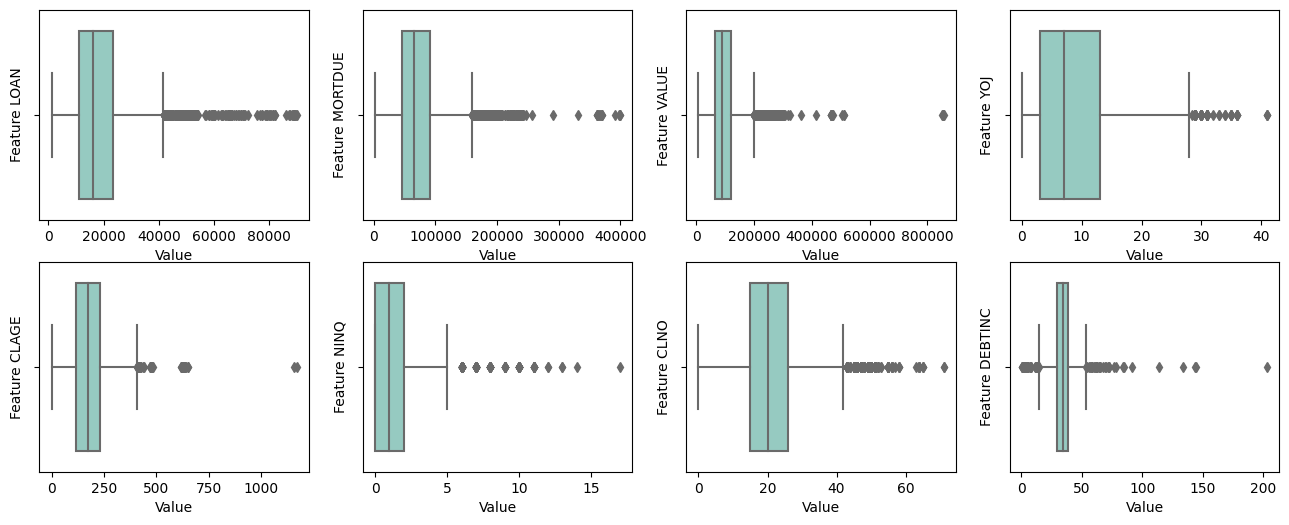

In [36]:
fig, axis = plt.subplots(2, 4, figsize = (16, 6))

actual_columns = X.select_dtypes(include = np.number).columns.tolist()

for index, column in enumerate(actual_columns):
    row = index // 4
    col = index % 4
    ax = axis[row][col]
    sns.boxplot(x = X[column], palette='Set3', ax = ax)
    ax.set_xlabel('Value')
    ax.set_ylabel(f'Feature {column}')
plt.show()

Removing outlliers in numerical columns

In [37]:
for column in actual_columns:
    X[column] = clean_outliers(X, column)

After applyting outliers removal

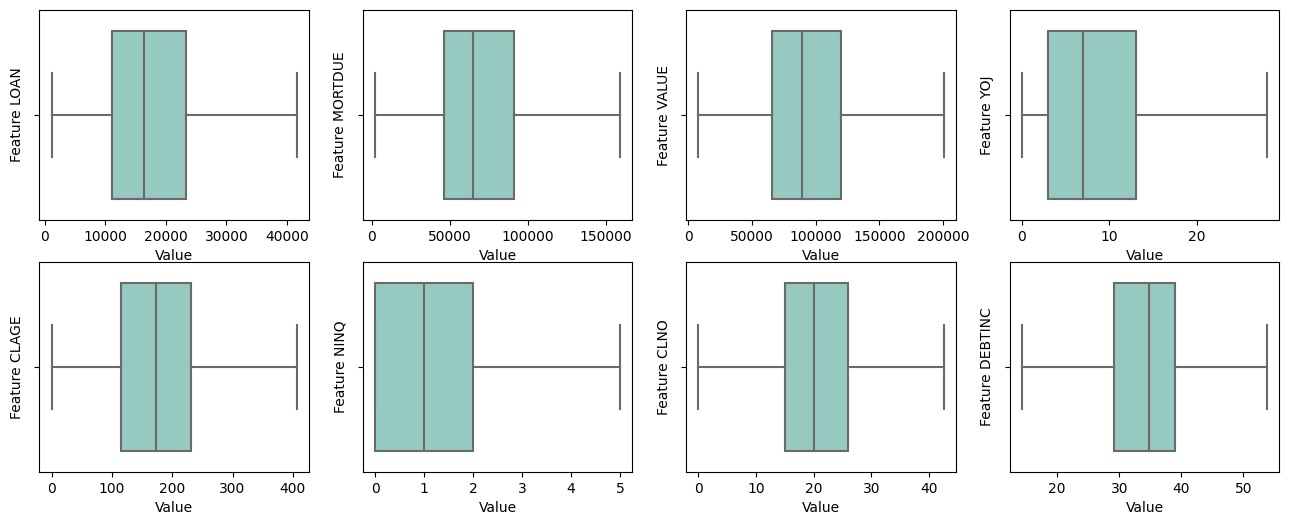

In [41]:
fig, axis = plt.subplots(2, 4, figsize = (16, 6))

actual_columns = X.select_dtypes(include = np.number).columns.tolist()

for index, column in enumerate(actual_columns):
    row = index // 4
    col = index % 4
    ax = axis[row][col]
    sns.boxplot(x = X[column], palette='Set3', ax = ax)
    ax.set_xlabel('Value')
    ax.set_ylabel(f'Feature {column}')
plt.show()

Analyzing distributionS so that it gets easier to decide the imputer

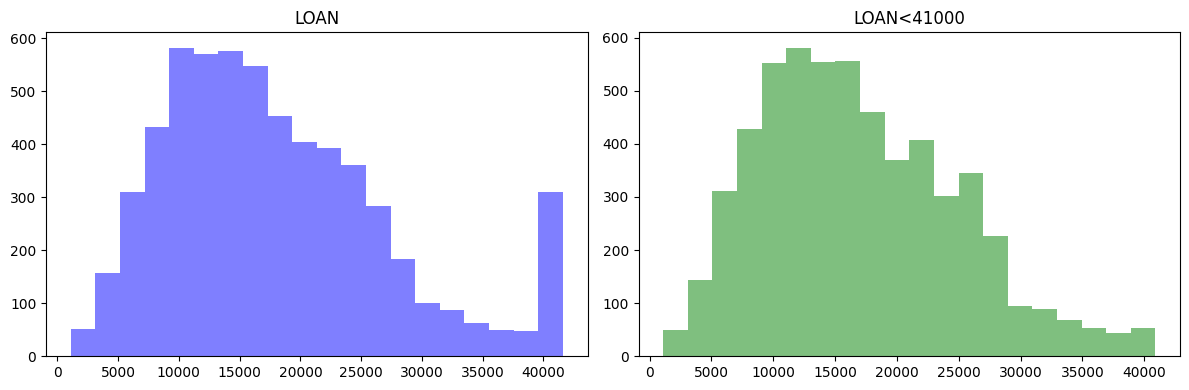

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(X['LOAN'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('LOAN')
axes[1].hist(X[data['LOAN']<41000]['LOAN'], bins=20, color='green', alpha=0.5)
axes[1].set_title('LOAN<41000')
plt.tight_layout()
plt.show()

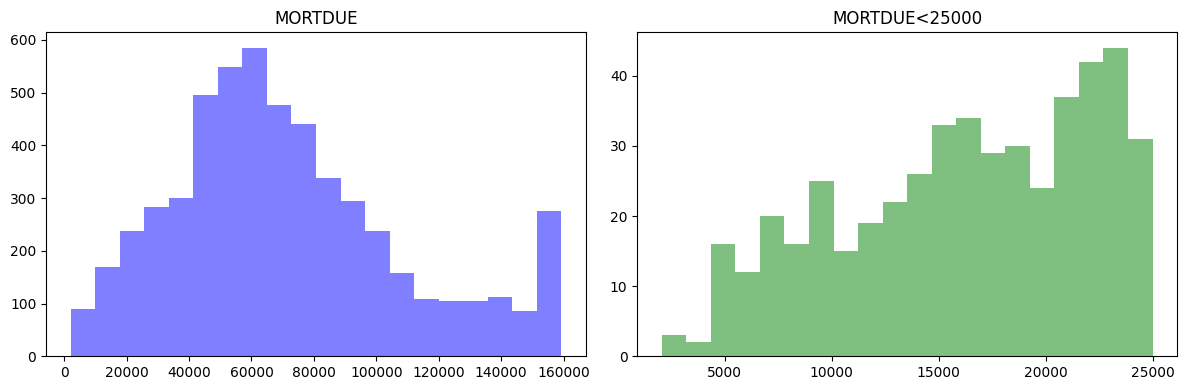

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
axes[0].hist(X['MORTDUE'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('MORTDUE')
axes[1].hist(X[X['MORTDUE']<25000]['MORTDUE'], bins=20, color='green', alpha=0.5)
axes[1].set_title('MORTDUE<25000')
plt.tight_layout()
plt.show()

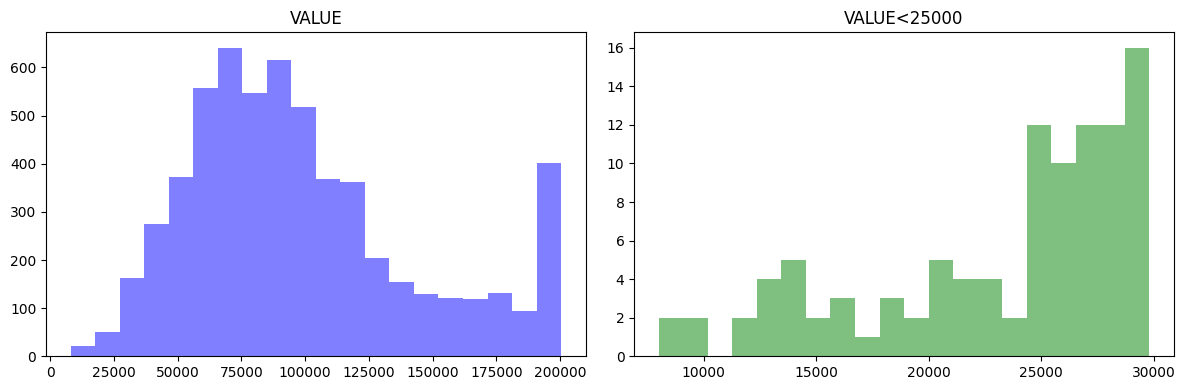

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
axes[0].hist(X['VALUE'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('VALUE')
axes[1].hist(X[X['VALUE']<30000]['VALUE'], bins=20, color='green', alpha=0.5)
axes[1].set_title('VALUE<25000')
plt.tight_layout()
plt.show()

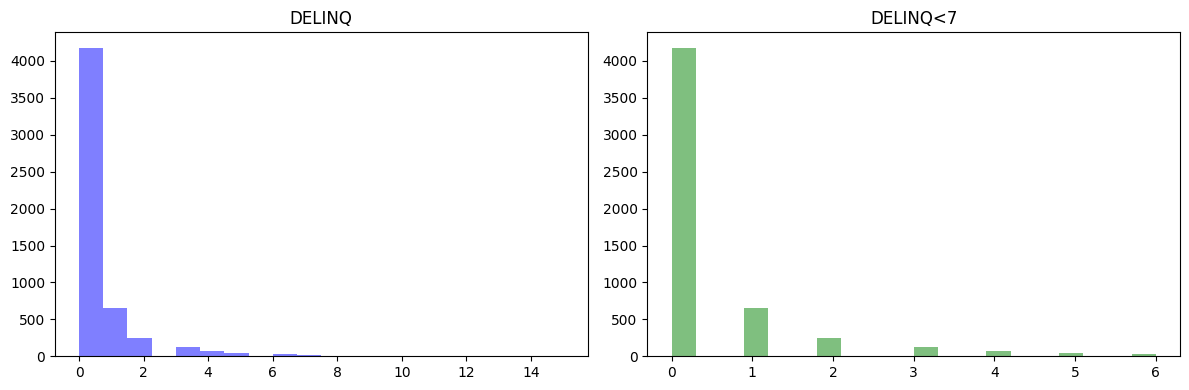

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
axes[0].hist(X['DELINQ'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('DELINQ')
axes[1].hist(X[X['DELINQ']<7]['DELINQ'], bins=20, color='green', alpha=0.5)
axes[1].set_title('DELINQ<7')
plt.tight_layout()
plt.show()

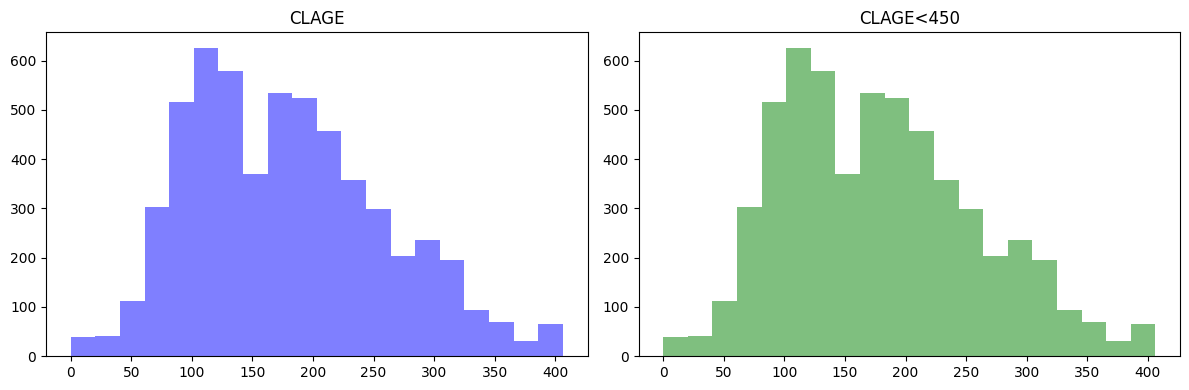

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
axes[0].hist(X['CLAGE'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('CLAGE')
axes[1].hist(X[X['CLAGE']<450]['CLAGE'], bins=20, color='green', alpha=0.5)
axes[1].set_title('CLAGE<450')
plt.tight_layout()
plt.show()

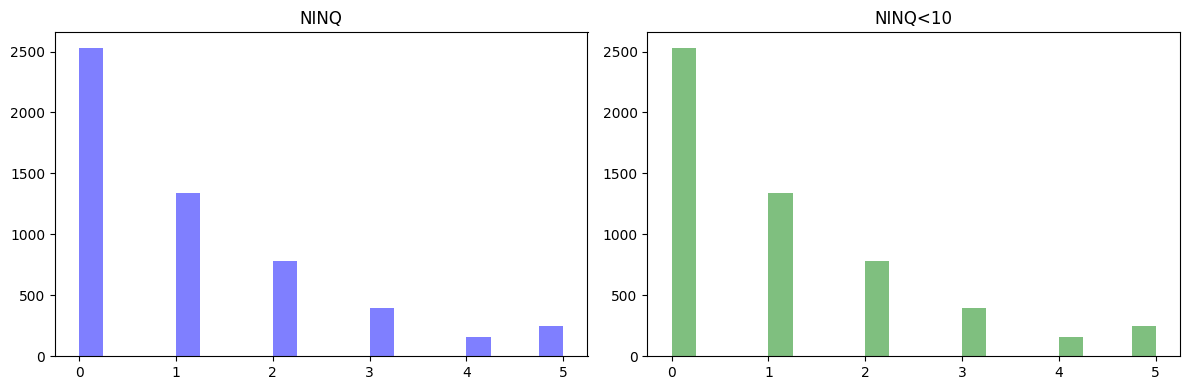

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(X['NINQ'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('NINQ')
axes[1].hist(X[X['NINQ']<10]['NINQ'], bins=20, color='green', alpha=0.5)
axes[1].set_title('NINQ<10')
plt.tight_layout()
plt.show()

Getting back intger features

In [58]:
X['DEROG'] = X['DEROG'].astype(float)
X['DELINQ'] = X['DELINQ'].astype(float)

Imputing X null values with median and encoding cat-object features

In [67]:
# divide columns by their dtype
num_col = X.select_dtypes(include = np.number).columns.tolist()
cat_col = X.select_dtypes(exclude = np.number).columns.tolist()

# declaring imputers
imputer = SimpleImputer(strategy = 'median').set_output(transform = 'pandas')
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform = 'pandas')

# declaring all transformations
transformer = ColumnTransformer([('NUM', imputer, num_col), ('CAT', encoder, cat_col)], remainder = 'passthrough')\
                                .set_output(transform = 'pandas')

# fitting transformer
X_tr = transformer.fit_transform(X)

Verifying there are no null values left

In [68]:
X_tr.isnull().sum().sum()

0

# Modelling

Getting base coefficients by calculating with the whole dataset as a first approach

In [81]:
model = LogisticRegression(solver = 'liblinear', random_state = 23)
model.fit(X_tr, y)
coefficients = model.coef_[0]
print("Intercept:", model.intercept_[0])

print("Coefficients:", model.coef_[0])

Intercept: -0.010249789981604881
Coefficients: [-2.46189166e-05 -4.32351505e-06 -3.74588681e-08 -1.23546804e-02
  9.55086771e-02  1.76923110e-01 -6.66031779e-03  7.76466212e-02
 -1.46511193e-03  1.26903244e-02 -1.33928268e-02  2.88217968e-03
  2.60857144e-04  4.20716410e-03 -1.62879122e-02  3.77806222e-03
 -2.13947495e-03  3.28772008e-03  5.32093148e-03 -8.41628070e-03]


Doing the same thing by applying bootstrap

In [78]:
def bootstrap_confidence_interval_logistic(flow_pipe, X, y, num_simulations = 10000):
    coefs = []
    num_samples = len(X)
    for _ in range(num_simulations):
        # Muestreo bootstrap
        idx = np.random.choice(range(num_samples), size=num_samples, replace=True)
        X_sampled, y_sampled = X.iloc[idx], y.iloc[idx]
        X_sampled_tr = flow_pipe.fit_transform(X_sampled)
 
        # Ajustar el modelo en la muestra
        model = LogisticRegression(solver = 'liblinear', random_state = 23)
        model.fit(X_sampled_tr, y_sampled)
        coefs.append(model.coef_[0])
    
    coefs = np.array(coefs)
    lower_percentile = np.percentile(coefs, 2.5, axis=0)
    upper_percentile = np.percentile(coefs, 97.5, axis=0)
    
    return lower_percentile, upper_percentile

In [79]:
# getting confidence interval from coefficents
lower_ci, upper_ci = bootstrap_confidence_interval_logistic(transformer, X, y)

print("Intervalos de confianza de los coeficientes:")
print("Intervalo Inferior:", lower_ci)
print("Intervalo Superior:", upper_ci)

Intervalos de confianza de los coeficientes:
Intervalo Inferior: [-3.17279259e-05 -6.91541698e-06 -2.89559245e-06 -1.75657569e-02
  7.46423336e-05  1.36031547e-04 -8.65060198e-03  6.99309467e-05
 -2.39082713e-04 -7.46664481e-05 -4.94273231e-03 -8.11029281e-06
 -1.27408808e-04  1.13518158e-06 -6.05478948e-03 -3.49394559e-06
 -1.07819018e-03  1.05322320e-06  2.85189004e-06 -3.21233853e-03]
Intervalo Superior: [-1.17225038e-05  9.39300628e-07  3.22563593e-06 -1.37592373e-04
  3.84718798e-02  7.16043014e-02 -4.88758194e-03  3.24117068e-02
  1.11872931e-02  2.60668898e-02 -3.66202713e-06  1.34462251e-03
  3.23365642e-04  1.78656501e-03 -1.08842359e-05  1.86003475e-03
  2.58905167e-06  1.27956267e-03  2.15370821e-03 -6.21040698e-06]


Putting all together into a table

In [83]:
bootstrap = pd.DataFrame({'Coefficient': coefficients,
                          '2.5%': lower_ci,
                          '97.5%': upper_ci})

bootstrap

,Coefficient,2.5%,97.5%
0,-2.461892e-05,-0.000032,-1.172250e-05
1,-4.323515e-06,-0.000007,9.393006e-07
2,-3.745887e-08,-0.000003,3.225636e-06
3,-1.235468e-02,-0.017566,-1.375924e-04
4,9.550868e-02,0.000075,3.847188e-02
5,1.769231e-01,0.000136,7.160430e-02
6,-6.660318e-03,-0.008651,-4.887582e-03
7,7.764662e-02,0.000070,3.241171e-02
8,-1.465112e-03,-0.000239,1.118729e-02
9,1.269032e-02,-0.000075,2.606689e-02


Plotting coefficients with their confidence intervals

In [89]:
coefficients

array([-2.46189166e-05, -4.32351505e-06, -3.74588681e-08, -1.23546804e-02,
        9.55086771e-02,  1.76923110e-01, -6.66031779e-03,  7.76466212e-02,
       -1.46511193e-03,  1.26903244e-02, -1.33928268e-02,  2.88217968e-03,
        2.60857144e-04,  4.20716410e-03, -1.62879122e-02,  3.77806222e-03,
       -2.13947495e-03,  3.28772008e-03,  5.32093148e-03, -8.41628070e-03])

In [3]:
import matplotlib
matplotlib.__version__

'3.7.2'

ValueError: 'yerr' must not contain negative values

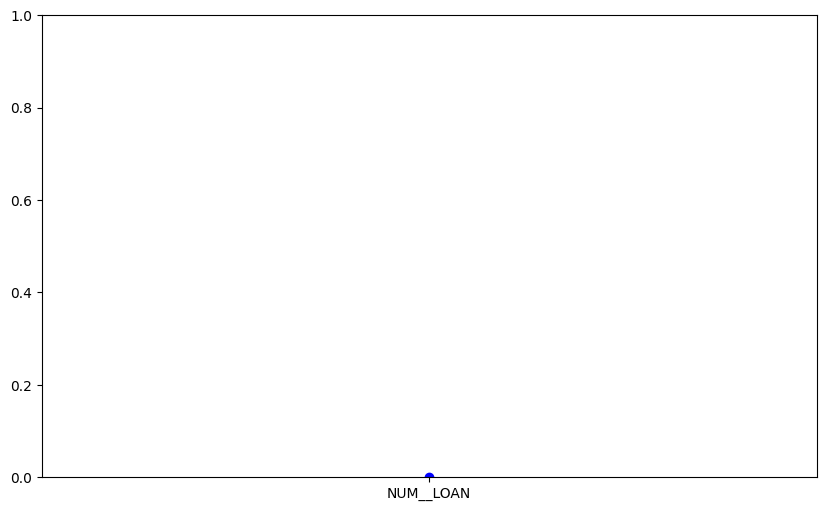

In [84]:
coefficent_names = X_tr.columns
plt.figure(figsize=(10, 6))

plt.errorbar(coefficent_names, coefficients, yerr = [coefficients - lower_ci, upper_ci - coefficients],
             fmt='o', color='blue', ecolor='orange', capsize=5, elinewidth=2)

plt.xlabel('Coefficients')
plt.ylabel('Coefficient Value')
plt.title('Coefficent values with confidence intervals')

plt.xticks(rotation=45)
plt.show()

<AxesSubplot:>

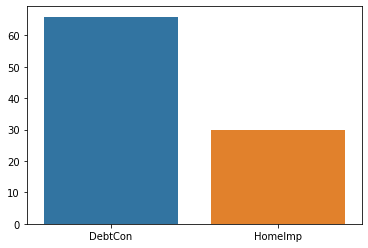

In [27]:
percentages = (Base['REASON'].value_counts() / len(Base)) * 100
sns.barplot(x=percentages.index, y=percentages.values)

<AxesSubplot:>

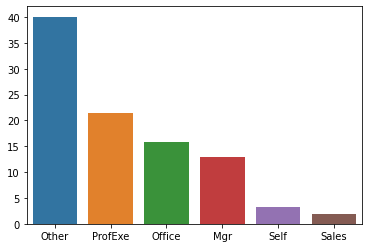

In [30]:
percentages = (Base['JOB'].value_counts() / len(Base)) * 100
sns.barplot(x=percentages.index, y=percentages.values)

In [43]:
Base[Base['CLAGE']<450]['CLAGE'].describe()

count    5623.000000
mean      177.502074
std        79.142034
min         0.000000
25%       114.906479
50%       172.767888
75%       230.254451
max       440.421254
Name: CLAGE, dtype: float64

In [44]:
Imputar_CLAGE=Base[Base['CLAGE']<450]['CLAGE'].mean()
print(Imputar_Value)
Base['CLAGE'] =  np.where(Base['CLAGE']>450,Imputar_CLAGE,Base['CLAGE'])
Base['CLAGE'] = np.where(Base['CLAGE'].isnull(), 150, Base['CLAGE'])

29800.0


In [45]:
print(Base[Base['NINQ'].isna()].shape[0]/Base.shape[0])
Base[Base['NINQ'].isna()]

0.08557046979865772


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3,1,1500.000000,16262.771937,25000.0,DebtCon,Other,9.362174,NaN,0.0,150.000000,NaN,NaN,NaN
10,1,2000.000000,22608.000000,25000.0,DebtCon,Other,18.000000,NaN,0.0,150.000000,NaN,NaN,NaN
17,1,2200.000000,23030.000000,25000.0,DebtCon,Other,19.000000,NaN,0.0,150.000000,NaN,NaN,3.711312
51,0,3100.000000,16262.771937,29800.0,DebtCon,Other,9.362174,NaN,0.0,150.000000,NaN,NaN,NaN
63,1,3600.000000,16262.771937,29800.0,HomeImp,ProfExe,10.000000,NaN,0.0,150.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5759,0,16935.114236,16262.771937,29800.0,DebtCon,Other,9.362174,5.0,0.0,116.437035,NaN,19.0,26.070435
5762,0,16935.114236,16262.771937,29800.0,DebtCon,Other,9.362174,5.0,0.0,130.496983,NaN,19.0,27.105116
5765,0,16935.114236,16262.771937,29800.0,DebtCon,Other,9.362174,5.0,0.0,128.656393,NaN,20.0,28.187140
5808,1,16935.114236,16262.771937,29800.0,HomeImp,Other,1.300000,0.0,1.0,103.133333,NaN,13.0,NaN


In [47]:
Imputar_NINQ=Base[Base['NINQ']<10]['NINQ'].mean()
print(Imputar_NINQ)
Base['NINQ'] =  np.where(Base['NINQ']>10,Imputar_NINQ,Base['NINQ'])
Base['NINQ'] = np.where(Base['NINQ'].isnull(), 5, Base['NINQ'])

1.108583055863855


In [48]:
Base['CLNO'].unique()

array([ 9., 14., 10., nan,  8., 17., 12., 13., 25., 24., 16., 22.,  0.,
        4., 21., 19., 45., 26., 37.,  3.,  2., 27., 20.,  7., 36., 33.,
        6., 28., 11., 31., 15., 18., 23.,  5., 30., 34., 42., 50., 47.,
       32., 29., 46., 38., 40., 49., 43., 35.,  1., 56., 39., 51., 55.,
       65., 57., 41., 71., 48., 53., 64., 52., 63., 44., 58.])

In [49]:
Base['MORTDUE'].describe()

count     5960.000000
mean     16265.703893
std       1653.534536
min       2063.000000
25%      16262.771937
50%      16262.771937
75%      16262.771937
max      25000.000000
Name: MORTDUE, dtype: float64

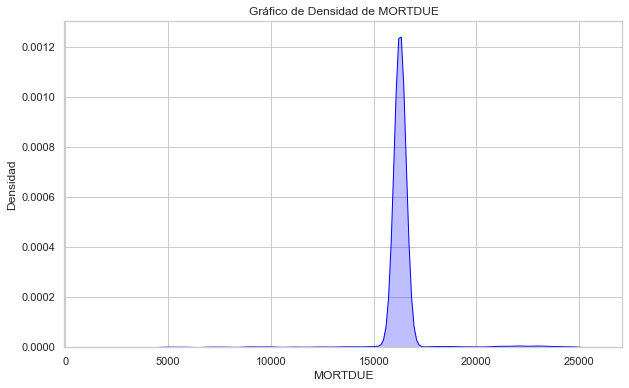

In [50]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.kdeplot(data=Base['MORTDUE'], fill=True, color="blue")

plt.title("Gráfico de Densidad de MORTDUE")
plt.xlabel("MORTDUE")
plt.ylabel("Densidad")

plt.show()

In [51]:
Base[Base['DEBTINC'].isna()]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100.000000,16262.771937,29800.0,HomeImp,Other,10.500000,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300.000000,16262.771937,29800.0,HomeImp,Other,7.000000,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500.000000,13500.000000,16700.0,HomeImp,Other,4.000000,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500.000000,16262.771937,25000.0,DebtCon,Other,9.362174,NaN,0.0,150.000000,5.0,NaN,NaN
4,0,1700.000000,16262.771937,29800.0,HomeImp,Office,3.000000,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,1,16935.114236,16262.771937,29800.0,DebtCon,Other,1.000000,0.0,0.0,117.166667,9.0,23.0,NaN
5932,1,16935.114236,16262.771937,29800.0,DebtCon,Other,12.000000,0.0,0.0,134.900000,0.0,26.0,NaN
5933,1,16935.114236,16262.771937,29800.0,HomeImp,Self,8.000000,1.0,2.0,71.533132,3.0,14.0,NaN
5935,0,16935.114236,13900.000000,29800.0,HomeImp,Other,27.000000,0.0,1.0,138.000000,0.0,14.0,NaN


In [52]:
print(Base[Base['DEBTINC'].isna()].shape)

(1267, 13)


In [53]:
bins = [0, 5000,10000,15000,20000,float('inf')] 
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k+']
Base['MORTDUE_Rango'] = pd.cut(Base['MORTDUE'], bins=bins, labels=labels, include_lowest=True)
media_debtinc_por_rango = Base.groupby('MORTDUE_Rango')['DEBTINC'].mean()

In [54]:
media_debtinc_por_rango

MORTDUE_Rango
0-5k       40.836453
5k-10k     26.971794
10k-15k    29.518648
15k-20k    34.010981
20k+       30.286589
Name: DEBTINC, dtype: float64

In [55]:
media_por_rango = {}
for rango in labels:
    media = Base[Base['MORTDUE_Rango'] == rango]['DEBTINC'].mean()
    media_por_rango[rango] = media
media_por_rango

{'0-5k': 40.836452556,
 '5k-10k': 26.971793721019594,
 '10k-15k': 29.518648409799997,
 '15k-20k': 34.0109811076626,
 '20k+': 30.286588966964054}

In [56]:
for rango, media in media_por_rango.items():
    Base.loc[(Base['DEBTINC'].isnull()) & (Base['MORTDUE_Rango'] == rango), 'DEBTINC'] = media

In [60]:
Base.DEROG.unique()

array([ 0., nan,  3.,  2.,  1.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

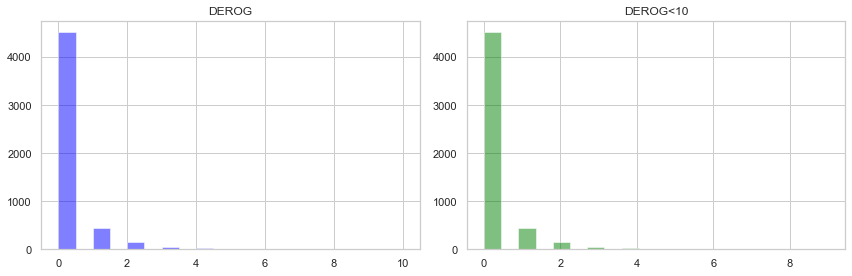

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(Base['DEROG'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('DEROG')
axes[1].hist(Base[Base['DEROG']<10]['DEROG'], bins=20, color='green', alpha=0.5)
axes[1].set_title('DEROG<10')
plt.tight_layout()
plt.show()

In [61]:
#Base['DEROG'] =  np.where(Base['NINQ']>10,Imputar_NINQ,Base['NINQ'])
Base['DEROG'] = np.where(Base['DEROG'].isnull(), 0, Base['DEROG'])

In [62]:
Base.isnull().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ                0
DEROG              0
DELINQ             0
CLAGE              0
NINQ               0
CLNO             222
DEBTINC            0
MORTDUE_Rango      0
dtype: int64

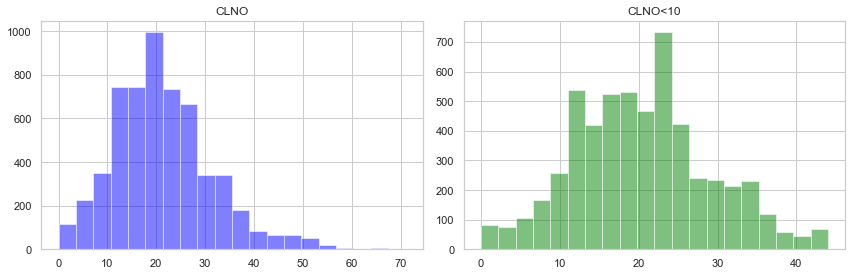

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(Base['CLNO'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('CLNO')
axes[1].hist(Base[Base['CLNO']<45]['CLNO'], bins=20, color='green', alpha=0.5)
axes[1].set_title('CLNO<10')
plt.tight_layout()
plt.show()

In [64]:
Q1 = Base['CLNO'].describe()['25%']
Q3 = Base['CLNO'].describe()['75%']
IQR = Q3 - Q1

print("Primer cuartil (Q1):", Q1)
print("Tercer cuartil (Q3):", Q3)
print("Rango Intercuartílico (IQR):", IQR)

Q3+1.5*IQR,Q3-1.5*IQR

Primer cuartil (Q1): 15.0
Tercer cuartil (Q3): 26.0
Rango Intercuartílico (IQR): 11.0


(42.5, 9.5)

In [67]:
Imputar_CLNO=Base[Base['CLNO']<45]['CLNO'].mean()
print(Imputar_CLNO)
Base['CLNO'] =  np.where(Base['CLNO']>45,Imputar_CLNO,Base['CLNO'])
Base['CLNO'] = np.where(Base['CLNO'].isnull(), 5, Base['CLNO'])

20.296917252568957


In [68]:
Base.isnull().sum()

BAD              0
LOAN             0
MORTDUE          0
VALUE            0
REASON           0
JOB              0
YOJ              0
DEROG            0
DELINQ           0
CLAGE            0
NINQ             0
CLNO             0
DEBTINC          0
MORTDUE_Rango    0
dtype: int64

In [85]:
Base_F = pd.merge(Base, pd.get_dummies(Base[['JOB','REASON','MORTDUE_Rango']]), left_index=True, right_index=True)
Base_F

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,JOB_ProfExe,JOB_Sales,JOB_Self,REASON_DebtCon,REASON_HomeImp,MORTDUE_Rango_0-5k,MORTDUE_Rango_5k-10k,MORTDUE_Rango_10k-15k,MORTDUE_Rango_15k-20k,MORTDUE_Rango_20k+
0,1,1100.000000,16262.771937,29800.0,HomeImp,Other,10.500000,0.0,0.0,94.366667,...,0,0,0,0,1,0,0,0,1,0
1,1,1300.000000,16262.771937,29800.0,HomeImp,Other,7.000000,0.0,2.0,121.833333,...,0,0,0,0,1,0,0,0,1,0
2,1,1500.000000,13500.000000,16700.0,HomeImp,Other,4.000000,0.0,0.0,149.466667,...,0,0,0,0,1,0,0,1,0,0
3,1,1500.000000,16262.771937,25000.0,DebtCon,Other,9.362174,0.0,0.0,150.000000,...,0,0,0,1,0,0,0,0,1,0
4,0,1700.000000,16262.771937,29800.0,HomeImp,Office,3.000000,0.0,0.0,93.333333,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,16935.114236,16262.771937,29800.0,DebtCon,Other,16.000000,0.0,0.0,221.808718,...,0,0,0,1,0,0,0,0,1,0
5956,0,16935.114236,16262.771937,29800.0,DebtCon,Other,16.000000,0.0,0.0,208.692070,...,0,0,0,1,0,0,0,0,1,0
5957,0,16935.114236,16262.771937,29800.0,DebtCon,Other,15.000000,0.0,0.0,212.279697,...,0,0,0,1,0,0,0,0,1,0
5958,0,16935.114236,16262.771937,29800.0,DebtCon,Other,14.000000,0.0,0.0,213.892709,...,0,0,0,1,0,0,0,0,1,0


In [86]:
Base_F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   BAD                    5960 non-null   int64   
 1   LOAN                   5960 non-null   float64 
 2   MORTDUE                5960 non-null   float64 
 3   VALUE                  5960 non-null   float64 
 4   REASON                 5960 non-null   object  
 5   JOB                    5960 non-null   object  
 6   YOJ                    5960 non-null   float64 
 7   DEROG                  5960 non-null   float64 
 8   DELINQ                 5960 non-null   float64 
 9   CLAGE                  5960 non-null   float64 
 10  NINQ                   5960 non-null   float64 
 11  CLNO                   5960 non-null   float64 
 12  DEBTINC                5960 non-null   float64 
 13  MORTDUE_Rango          5960 non-null   category
 14  JOB_Mgr                5960 non-null   u

In [87]:
X=Base_F.drop(['BAD','REASON','JOB','MORTDUE_Rango'],axis=1)
y=Base_F[['BAD']]
print(X.shape,y.shape)

(5960, 23) (5960, 1)


In [88]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
model.fit(X, y)

print("Intercepto:", model.intercept_[0])
import warnings
print("Coeficientes:", model.coef_[0])

Intercepto: 0.0009566097258696862
Coeficientes: [-3.31821353e-05  1.03706040e-04 -1.32877420e-04 -1.43514585e-03
  3.37101608e-02  6.06117003e-02 -5.37247847e-03  2.75711511e-02
 -2.02067496e-03  6.48620210e-02  1.91867076e-03 -4.35453126e-03
  2.07350184e-03 -1.13247910e-03  1.03123324e-03  1.42021425e-03
 -8.01551234e-04  1.75816096e-03  4.51066736e-04  9.06303611e-04
  5.14261762e-04 -5.45400598e-04 -3.69621785e-04]


/Users/jorgefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [90]:

model = LogisticRegression(solver='liblinear')
model.fit(X, y)

print("Intercepto:", model.intercept_[0])

print("Coeficientes:", model.coef_[0])

def bootstrap_confidence_interval_logistic(X, y, num_simulations=10000):
    coefs = []
    num_samples = len(X)
    for _ in range(num_simulations):
        # Muestreo bootstrap
        idx = np.random.choice(range(num_samples), size=num_samples, replace=True)
        X_sampled, y_sampled = X.iloc[idx], y.iloc[idx]
        
        # Ajustar el modelo en la muestra
        model.fit(X_sampled, y_sampled)
        coefs.append(model.coef_[0])
    
    coefs = np.array(coefs)
    lower_percentile = np.percentile(coefs, 2.5, axis=0)
    upper_percentile = np.percentile(coefs, 97.5, axis=0)
    
    return lower_percentile, upper_percentile

# Obtener intervalos de confianza de los coeficientes
lower_ci, upper_ci = bootstrap_confidence_interval_logistic(X, y)

print("Intervalos de confianza de los coeficientes:")
print("Intervalo Inferior:", lower_ci)
print("Intervalo Superior:", upper_ci)

Intervalos de confianza de los coeficientes:
Intervalo Inferior: [-4.36411928e-05  5.02451990e-05 -1.79516504e-04 -1.97396258e-02
  1.54275639e-02  2.79622132e-02 -6.74291519e-03  1.28515057e-02
 -2.06657266e-02  3.83818022e-02  1.65021594e-04 -1.37462428e-01
 -5.78469416e-03 -2.24853280e-02  4.25109540e-04  5.99350768e-04
 -5.07216436e-02  1.25986666e-04  1.72332136e-04  3.46457002e-04
  5.74702506e-05 -3.92371045e-02 -1.26302703e-02]
Intervalo Superior: [-2.23883527e-05  1.57489802e-04 -9.96318825e-05  1.44792982e-02
  5.52015919e-01  7.86299813e-01 -4.46796242e-03  1.42340516e-01
  1.66402290e-02  8.87671034e-02  5.03792584e-02 -1.92496677e-03
  5.63000464e-02  2.74256975e-02  4.55236665e-02  4.99586612e-02
  6.75559696e-03  7.12842026e-02  1.49429116e-02  3.41008039e-02
  1.76157434e-02  1.84540484e-03  8.96261256e-03]


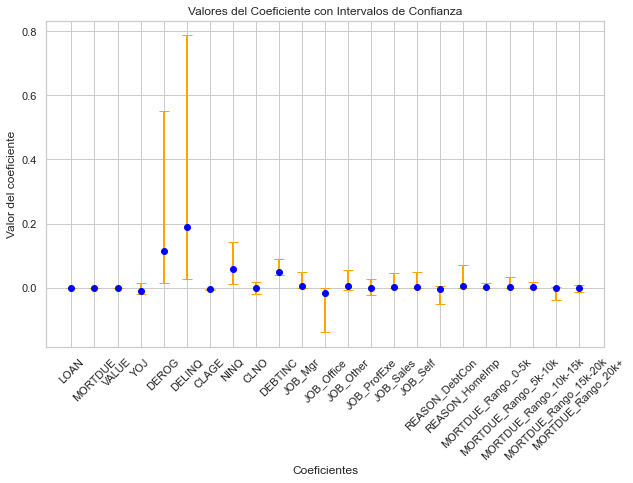

In [94]:
coeficientes = model.coef_[0]
nombres_coeficientes=X.columns
plt.figure(figsize=(10, 6))

plt.errorbar(nombres_coeficientes, coeficientes, yerr=[coeficientes - lower_ci, upper_ci - coeficientes],
             fmt='o', color='blue', ecolor='orange', capsize=5, elinewidth=2)

plt.xlabel('Coeficientes')
plt.ylabel('Valor del coeficiente')
plt.title('Valores del Coeficiente con Intervalos de Confianza')

plt.xticks(rotation=45)  # Rotación de las etiquetas del eje x para una mejor visualización

plt.show()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

model = smf.ols('y ~ X', data=X.columns).fit()  # Ejemplo para regresión lineal

# O suponiendo que has ajustado el modelo directamente con sm (sm.OLS o sm.Logit)
model = sm.OLS(y, X).fit()  # Ejemplo para regresión lineal

# Obtener el resumen del modelo
summary = model.summary()

# Obtener los coeficientes y sus intervalos de confianza del resumen del modelo
conf_int = summary.tables[1]  # Obtener la segunda tabla del resumen que contiene los coeficientes e intervalos de confianza
conf_int = pd.DataFrame(conf_int.data[1:], columns=conf_int.data[0])  # Convertir la tabla en un DataFrame

print(conf_int)
